In [1]:
import json
from typing import Dict, List, Tuple

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import torch
from torchvision.ops.boxes import box_iou

In [3]:
class Matrix:
    def __init__(
        self,
        ann_file: str = r'//aka/work/hara.e/AMED/lib/dataset/annotations/test.json',
        preds_file: str = r'//aka/work/hara.e/AMED/weights/YOLOX/four/metric0.35.json',
        iou_th: float = 0.25,
        conf_th: float = 0.3
    ) -> None:
        self.ann_file = ann_file
        self.preds_file = preds_file
        self.iou_th, self.conf_th = iou_th, conf_th

        self.ann, self.preds = self.reformat()

    def create_mat(self) -> np.ndarray:
        mat = np.zeros((5, 5))

        for i in range(len(self.preds)):
            mat_temp = np.zeros((5, 5)).astype(np.int32)
            row = self.preds.iloc[i, :]
            label = row["label"]

            # FN
            if 0 in row["preds"]:
                mat_temp[label, 0] += 1
            elif (np.array(row["iou"]) > self.iou_th).sum() >= 2:
                pred = row["preds"][np.array(row["reliability"]).argmax()]
                mat_temp[label, pred] += 1
            # detected
            else:
                for pred, iou in zip(row["preds"], row["iou"]):
                    if iou >= self.iou_th:
                        mat_temp[label, pred] += 1
                    # FP
                    else:
                        mat_temp[0, pred] += 1
                        mat_temp[label, 0] += 1

            for j, diagnosis in enumerate(mat_temp):
                if j == 0:
                    continue
                while diagnosis.sum() >= 2:
                    mat_temp[j, 0] -= 1

            mat += mat_temp

        return mat.astype(np.int32)

    def reformat(self) -> Tuple[pd.DataFrame]:
        ann_data, preds_data = self.read_data()
        ann = pd.DataFrame(
            self.reformat_ann(ann_data)
        )
        preds = pd.DataFrame(
            self.reformat_preds(preds_data)
        )

        df_iou = {"iou": []}
        for i in range(len(preds)):
            iou = Matrix.calc_iou(
                preds.iloc[i]["bbox"], ann.iloc[i]["bbox"]
            )
            df_iou["iou"].append(iou)
        df_iou = pd.DataFrame(df_iou)

        preds["label"] = ann["category_id"]
        preds["iou"] = df_iou["iou"]

        return ann, preds

    def reformat_ann(self, ann_data) -> Dict:
        return {
            "id": [data["id"] for data in ann_data],
            "category_id": [data["category_id"] for data in ann_data],
            "bbox": [data["bbox"] for data in ann_data]
        }

    def reformat_preds(self, preds_data) -> Dict:
        return {
            "file_name": [name for name in preds_data["file_name"]],
            "preds": [preds for preds in preds_data["preds"]],
            "reliability": [preds for preds in preds_data["reliability"]],
            "bbox": [preds for preds in preds_data["bbox"]]
        }

    def read_data(self) -> Tuple[Dict, Dict]:
        with open(self.ann_file, "r") as f:
            ann = json.load(f)["annotations"]

        with open(self.preds_file, "r") as f:
            preds = json.load(f)

        return ann, preds

    @staticmethod
    def calc_iou(pred: List, label: List) -> List:
        x, y, w, h = label
        if pred != [[]]:
            pred, label = torch.Tensor(pred), torch.Tensor([[x, y, x + w, y + h]])
            iou = box_iou(pred, label)
        else:
            iou = torch.Tensor([[0.]])

        return iou.flatten().tolist()

In [4]:
mat = Matrix(
    ann_file=r'//aka/work/hara.e/AMED/lib/dataset/annotations/test.json',
    preds_file=r"//aka/work/hara.e/AMED/weights/centernet/stepwise2/metric0.3.json",
    iou_th=0.2,
)

Text(30.453125, 0.5, 'Ground Truth')

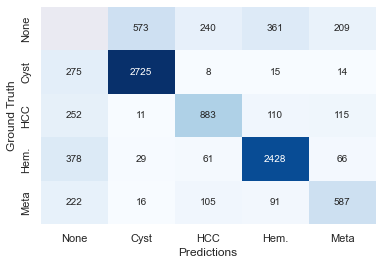

In [5]:
cmat = mat.create_mat()
tics = ["Cyst", "HCC", "Hem.", "Meta"]

mask = np.array([[1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])

sns.heatmap(
    cmat[:, :],
    cmap="Blues",
    annot=True,
    fmt='d',
    cbar=False,
    xticklabels=["None"] + tics,
    yticklabels=["None"] + tics,
    mask=mask
)

plt.xlabel("Predictions")
plt.ylabel("Ground Truth")

In [6]:
precision = []
eps = 1e-8

for i in range(len(cmat)):
    precision.append(cmat[i, i] / (cmat[: , i].sum()+eps))

pre = np.diag(cmat).sum() / cmat[:, 1:].sum()

print(precision[1: ])
print("macro:", np.array(precision[1:]).mean())
print("micro:", pre)

[0.8124627310649599, 0.6808018504188065, 0.8079866888492246, 0.5923309788033064]
macro: 0.7233955622840744
micro: 0.7659303804787788


In [7]:
recall = []

for i in range(len(cmat)):
    recall.append(cmat[i, i] / cmat[i].sum())

re = np.diag(cmat).sum() / cmat[1:, :].sum()

print(recall[1: ])
print("macro:", np.array(recall[1:]).mean())
print("micro:", re)

[0.8972670398419493, 0.6440554339897885, 0.8197164078325456, 0.574926542605289]
macro: 0.7339913560673932
micro: 0.7892980574424979


In [8]:
eps = 1e-8
f1 =[]

for p, r in zip(precision, recall):
    f1.append(2 * p * r / (p + r + eps))

print(f1[1: ])
print("macro:", np.array(f1).mean())
print("micro:", 2 * pre * re / (pre + re))

[0.8527616911461572, 0.6619190354811256, 0.8138092793964155, 0.5834990009624264]
macro: 0.582397801397225
micro: 0.7774386665101538
